## Imports

In [1]:
import glob
from typing import List

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading Data

In [2]:
original_img_paths = glob.glob("./original_images_cs558_bw1/*")

In [3]:
from PIL import Image

def load_pgm(filename: str) -> List[List[int]]:
    '''Allows us to convert images from its binary form to a 2D list representing the grayscale image.'''
    with Image.open(filename) as img:
        # Convert the image to grayscale
        img = img.convert('L')

        # Get image data as a list of lists (2D list)
        image_data = list(img.getdata())
        width, height = img.size
        print(f"Dimensions of {filename}: {width} x {height}")
        image_data = [image_data[i * width: (i + 1) * width] for i in range(height)]

    return image_data


In [4]:
original_images_list = [
    load_pgm(filename) for filename in original_img_paths
]

Dimensions of ./original_images_cs558_bw1/red.pgm: 321 x 481
Dimensions of ./original_images_cs558_bw1/plane.pgm: 481 x 321
Dimensions of ./original_images_cs558_bw1/kangaroo.pgm: 481 x 321


In [5]:
original_images_dict = dict(zip(
    ["Red", "Plane", "Kangaroo"], original_images_list
))

## Part 1: Gaussian Filtering of the Input Image

Based on an earlier run of this code, we visualized Gaussian smoothening of all 3 images using `sigma` values from 1 to 10:
![All the images + their smoothed versions, using sigma 1-10](./part_1_smoothed_images/attempt-1-incorrect-padding.png)

Unfortunately, these images got clipped accidentally because I messed up my zero padding function 😅.
So for the visualization below - we'll run the smoothening function again. And as per the submission requirements, we'll only use 2 different `sigma` values - specifically, `3` and `8`:

In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid
from util.gaussian_derivative import GaussianDerivativeFilter

In [11]:
# get a 1D array of all the images, smoothed at all values of sigma:
smoother = GaussianDerivativeFilter()
smoothed_images_all2 = list()
sigma_values = [3, 8]  # originally, this was len(range(1, 11))

for image_name, image in original_images_dict.items():
    # first, add the normal image for comparison later on
    smoothed_images = [(image_name, image)]
    for sigma in sigma_values:
        filter_matrix = smoother.create_gaussian_filter(sigma)
        smoothed_image = smoother.smooth(image, filter_matrix)
        smoothed_images.append((image_name, smoothed_image))
    smoothed_images_all2.extend(smoothed_images)


In [12]:
# checking dims of the convolutions - purely a sanity check
new_im_count = 0
for _, im  in smoothed_images_all2:
    print(len(im), len(im[0]))
    new_im_count= (new_im_count + 1)
    if new_im_count % 3 == 0:
        print("-------------")

481 321
481 321
481 321
-------------
321 481
321 481
321 481
-------------
321 481
321 481
321 481
-------------


In [13]:
from PIL import Image

In [14]:
i = 0
for _, raster_matrix in smoothed_images_all2:
    arr = np.asarray(raster_matrix).astype(np.uint8)
    im = Image.fromarray(arr)
    i += 1
    im.save(f"./part_1_smoothed_images/{i}.png")

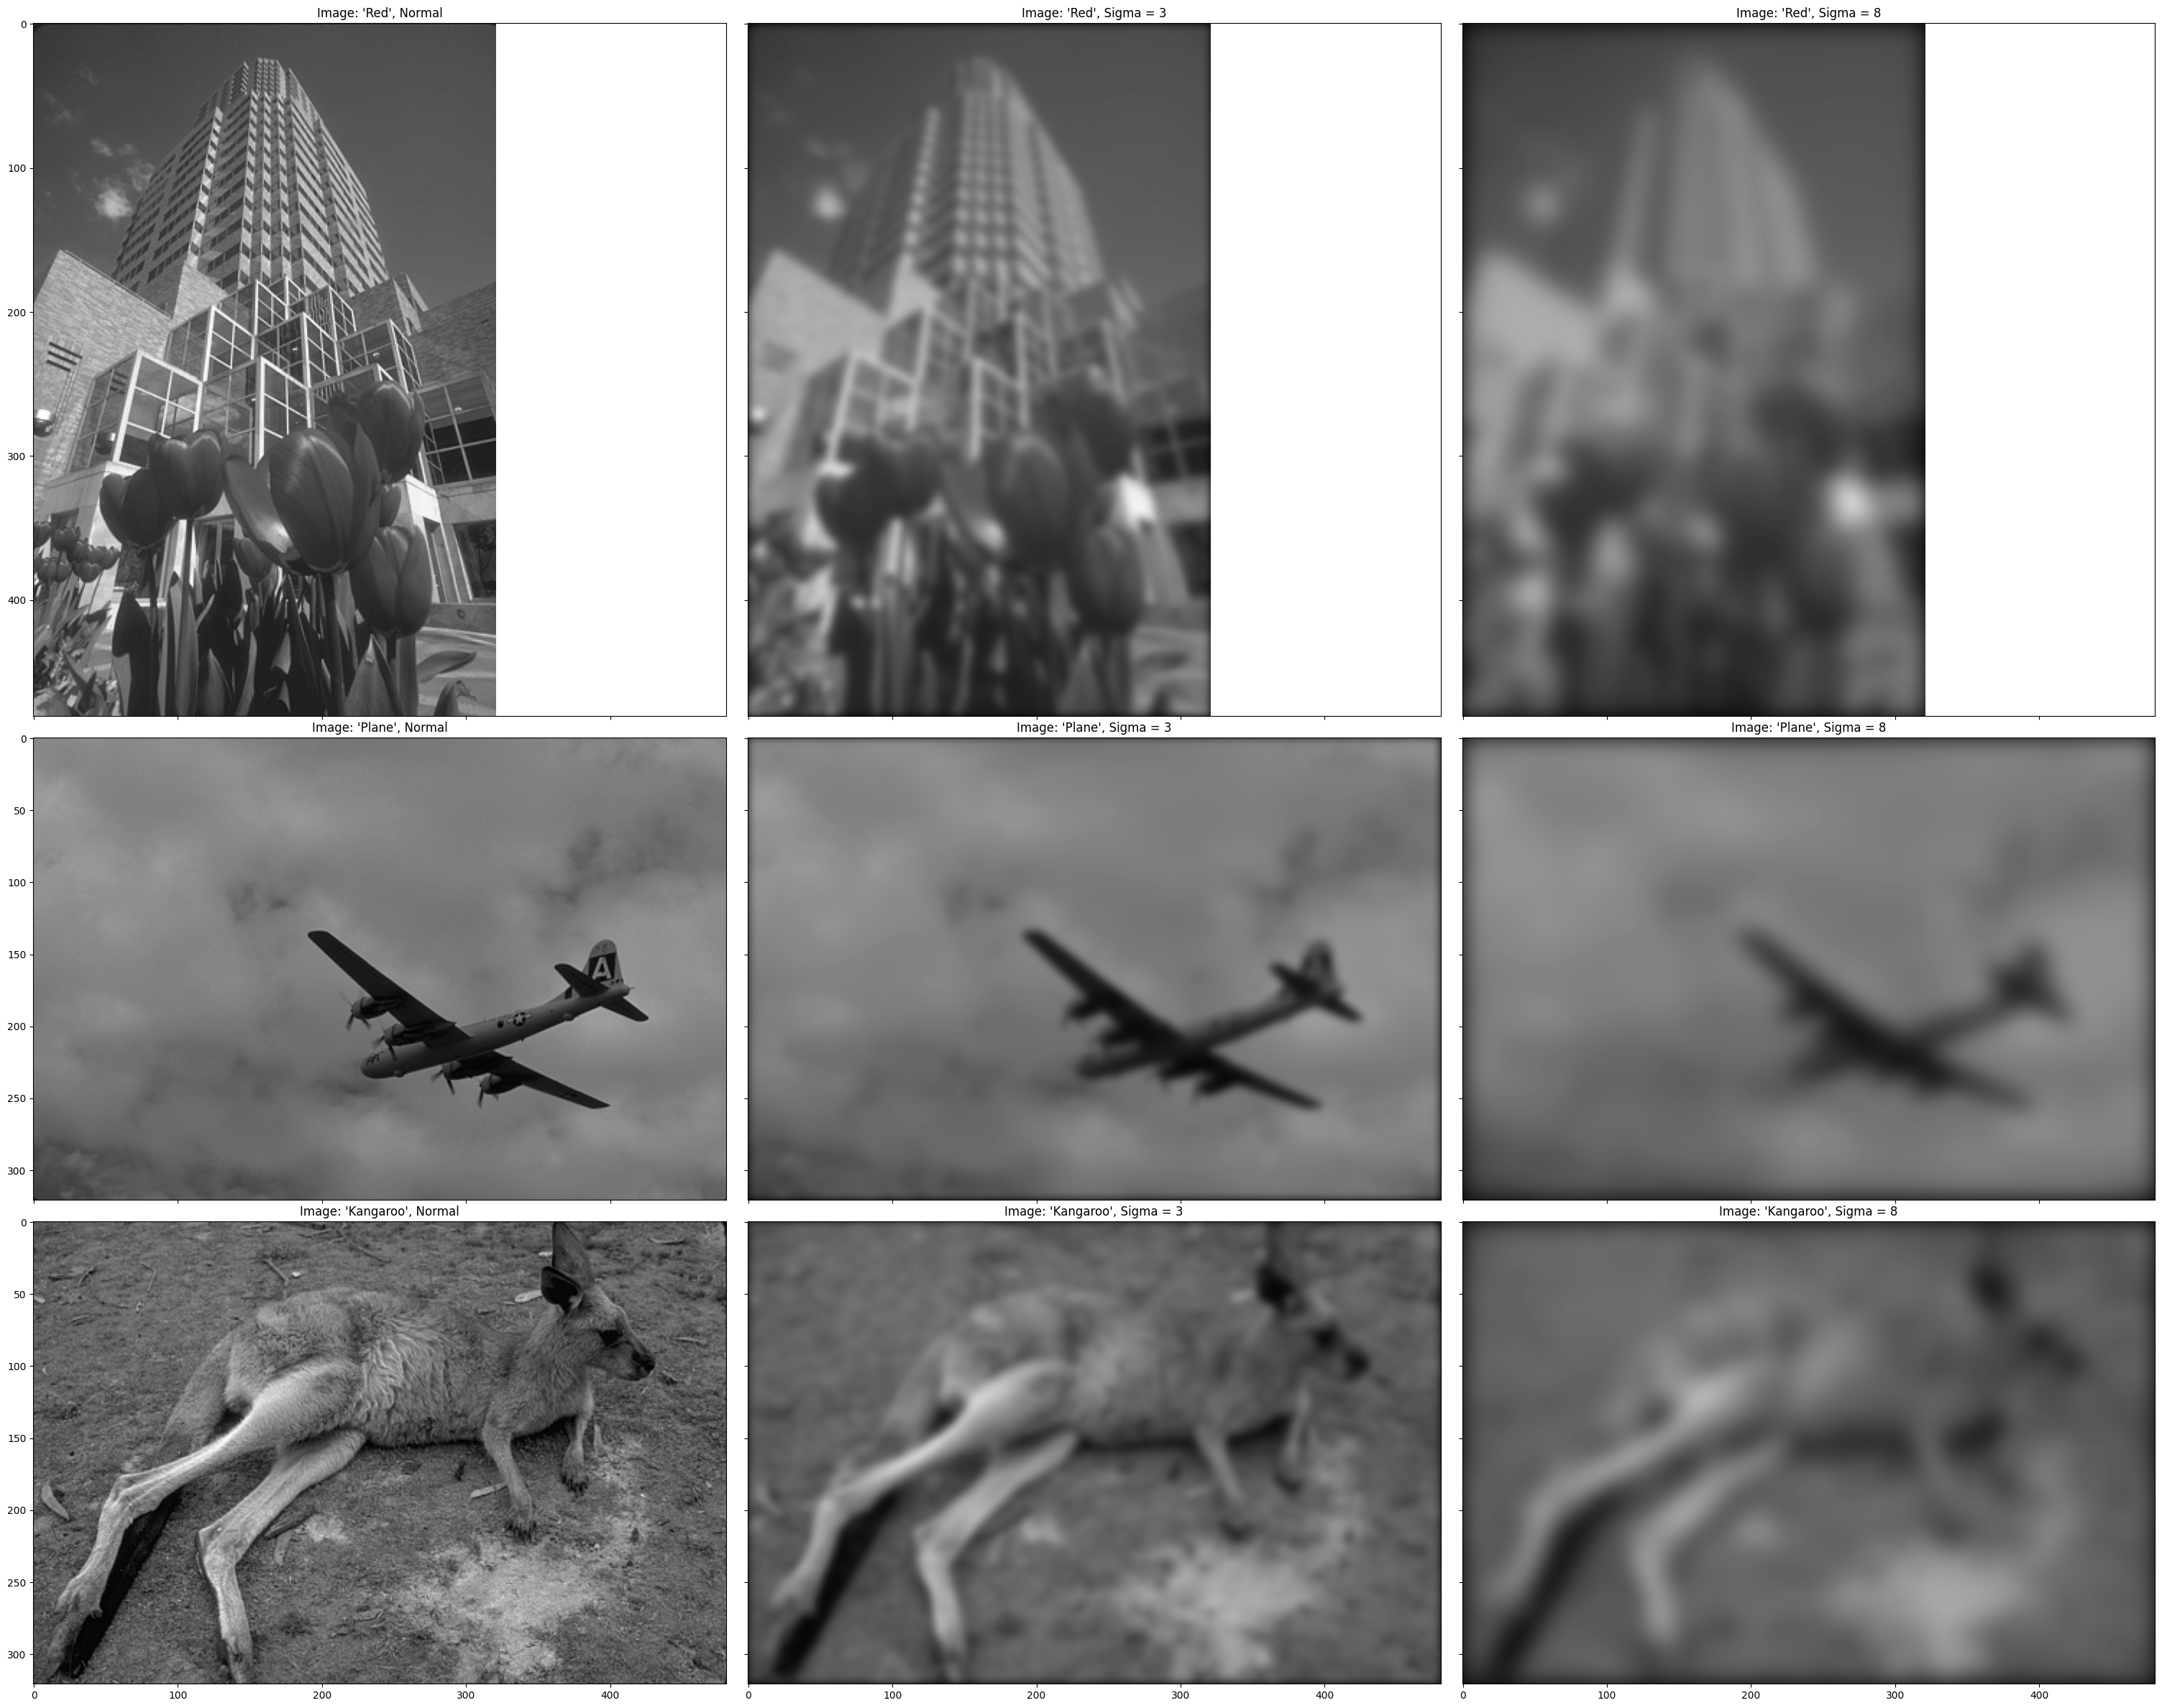

In [15]:
fig = plt.figure(figsize=(400., 30.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 3x3 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                )

image_index_to_name = {
    1: "Red",
    2: "Plane",
    3: "Kangaroo"
}
plot_index = 0
for ax, im in zip(grid, smoothed_images_all2):
    # show image
    ax.imshow(im[1], cmap='gray', vmin=0, vmax=255)

    # configure plot title
    sigma = None
    if plot_index % 3 == 0:
        sigma = "Normal"
    elif plot_index % 3 == 1:
        sigma = "Sigma = 3"
    elif plot_index % 3 == 2:
        sigma = "Sigma = 8"
    
    image_name = image_index_to_name[plot_index // 3 + 1]
    plot_title = f"Image: '{image_name}', {sigma}"

    grid.axes_all[plot_index].set_title(plot_title)

    plot_index += 1

plt.show()

In [ ]:
fig.savefig("./part_1_smoothed_images/smoothening_with_sigma_equals_3_and_8.png")

## Part 2: Gradient Computation using the Sobel filters

In [41]:
def detect_edges_and_visualize(image, image_name,
                               sigma, threshold):
    '''Convenience wrapper + uses Matplotlib to plot the edges found.'''
    edge_detector = GaussianDerivativeFilter(sigma=sigma)  # I guess this should be a good value?
    detected_edges = edge_detector.detect_edges(image, threshold)
    plt.imshow(detected_edges, cmap='gray', vmin=0, vmax=255)
    plt.title(f"{image_name} Edges, sigma={sigma}, threshold={threshold}")
    plt.show()
    

### The "Kangaroo" Image

In [6]:
image = original_images_dict["Kangaroo"]

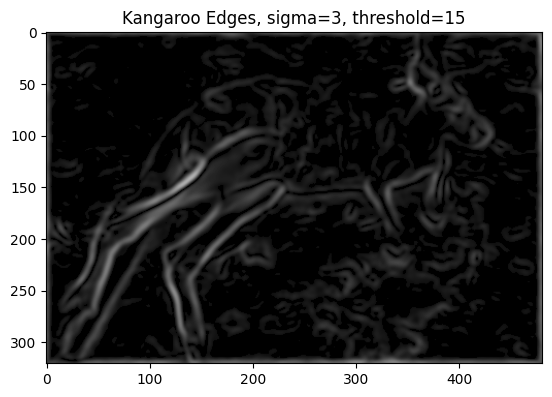

In [42]:
detect_edges_and_visualize(image, "Kangaroo", 3, 15)

### The "Plane" Image

In [43]:
image = original_images_dict["Plane"]

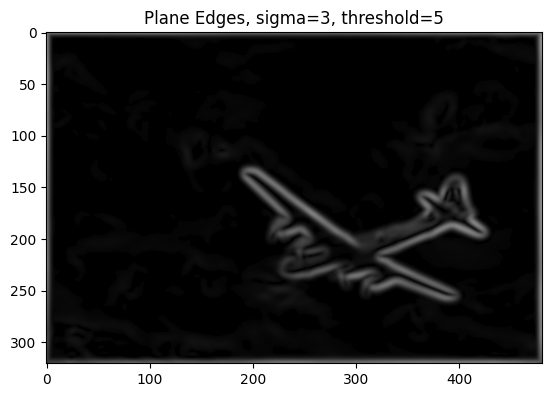

In [45]:
detect_edges_and_visualize(image, "Plane", 3, 5)

### The "Red" Image

In [46]:
image = original_images_dict["Red"]

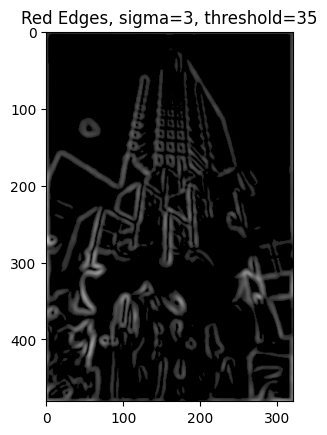

In [51]:
detect_edges_and_visualize(image, "Red", 3, 35)

It's interesting that at a threshold of `35`, we're able to make out the edges of the white cloud in the sky (towards the left of the image); but we're still not able to detect the left-side outline of the building, or the red roses near the bottom of the frame. This suggests my approach is not robust to object edges which don't "stand out" from their surrounds in terms of intensity.